In [3]:
import sys
print(sys.version)

3.13.0 (tags/v3.13.0:60403a5, Oct  7 2024, 09:38:07) [MSC v.1941 64 bit (AMD64)]


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Load the dataset
df = pd.read_excel('Raw data_Impulse buying behavior.xlsx')

# Preview the dataset
df.head().style.set_properties(**{"background-color": "#457B9D","color":"#A8DADC","border": "1.5px solid Yellow"})

,SC1,SC2,SC3,SC4,SI1,SI2,SI3,SI4,SI5,TR1,TR2,TR3,TR4,TR5,HM1,HM2,HM3,SL1,SL2,SL3,SL4,PP1,PP2,PP3,PP4,OIB1,OIB2,OIB3,Q1_PROVINCE/CITY,Q2_GENDER,Q3_SCHOOL,Q4_INCOME
0,5,5,5,5,5,3,5,3,3,5,3,3,5,5,2,5,5,3,4,5,3,3,3,3,5,3,5,3,Can Tho,0,1,1
1,4,3,4,3,3,4,4,3,4,2,3,4,4,5,3,2,4,5,3,4,5,4,3,4,3,2,4,3,Ca Mau,1,1,2
2,4,2,2,2,3,5,4,5,3,3,1,5,3,3,4,4,3,3,3,3,4,4,4,4,4,3,2,2,Ca Mau,0,1,2
3,2,3,1,1,5,4,4,3,4,4,1,4,3,4,4,5,3,2,3,5,2,4,4,4,4,2,4,3,Hau Giang,1,1,1
4,4,4,3,3,4,4,4,4,3,5,4,3,3,4,3,4,5,4,4,3,5,3,4,5,4,3,3,3,An Giang,0,3,1


In [6]:
df.describe().style.background_gradient(cmap='tab20c')


,SC1,SC2,SC3,SC4,SI1,SI2,SI3,SI4,SI5,TR1,TR2,TR3,TR4,TR5,HM1,HM2,HM3,SL1,SL2,SL3,SL4,PP1,PP2,PP3,PP4,OIB1,OIB2,OIB3,Q2_GENDER,Q3_SCHOOL,Q4_INCOME
count,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000
mean,3.833795,3.853186,3.878116,3.808864,3.991690,3.878116,3.889197,3.858726,3.958449,3.894737,3.324100,3.878116,3.609418,3.578947,3.869806,4.080332,3.650970,3.855956,3.781163,3.828255,3.814404,4.027701,3.941828,3.919668,3.966759,3.817175,3.855956,3.941828,0.349030,3.060942,1.950139
std,0.906807,0.899412,0.907740,0.957154,0.790526,0.753947,0.740810,0.714522,0.803424,0.945751,0.967644,0.937842,0.894315,0.881917,0.861009,1.006466,0.948716,0.837506,0.819403,0.794690,0.810633,0.781244,0.726059,0.727764,0.744612,0.618990,0.611259,0.649312,0.477325,2.460047,0.848369
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,3.000000,3.000000,3.000000,3.000000,4.000000,3.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,0.000000,1.000000,1.000000
50%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,0.000000,2.000000,2.000000
75%,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,5.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,1.000000,4.000000,2.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,8.000000,4.000000


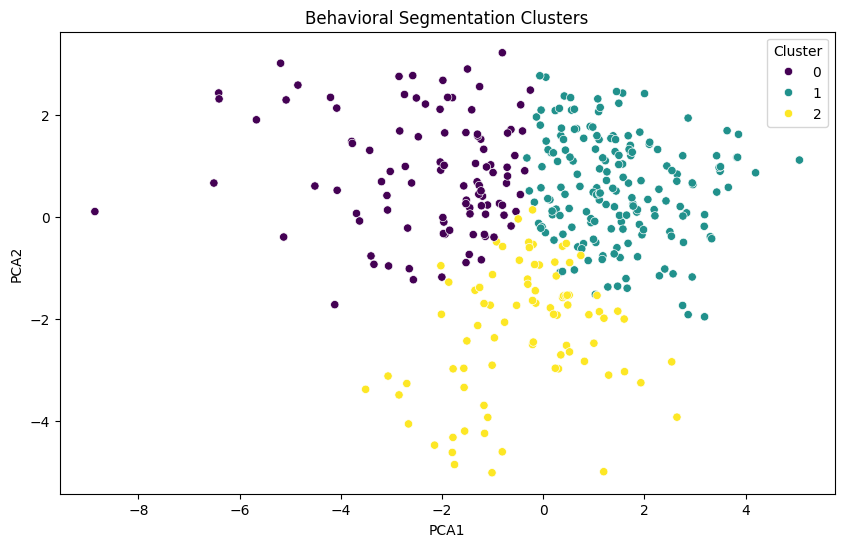

In [7]:
# Behavioral Segmentation using K-Means Clustering
features = ['SC1', 'SC2', 'SC3', 'SC4', 'SI1', 'SI2', 'SI3', 'SI4', 'SI5', 'TR1', 'TR2', 'TR3', 'TR4', 'TR5']
X = df[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df['PCA1'], df['PCA2'] = X_pca[:, 0], X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df, palette='viridis')
plt.title("Behavioral Segmentation Clusters")
plt.show()


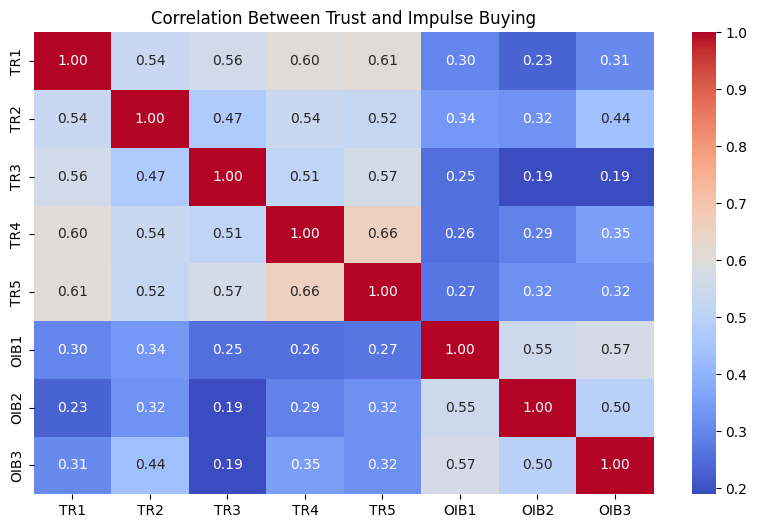

In [8]:
trust_vars = ['TR1', 'TR2', 'TR3', 'TR4', 'TR5']
oib_vars = ['OIB1', 'OIB2', 'OIB3']
correlation_matrix = df[trust_vars + oib_vars].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Trust and Impulse Buying")
plt.show()

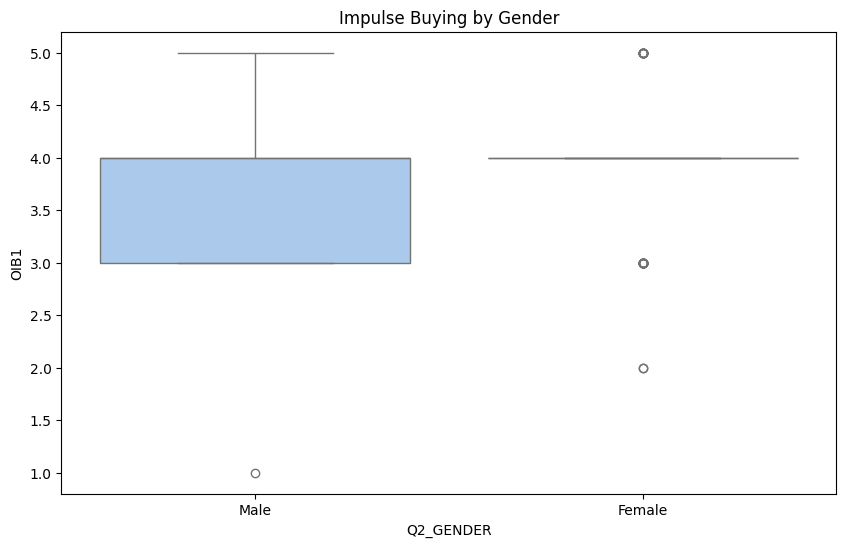

In [9]:
# Gender-Based Insights
plt.figure(figsize=(10, 6))
sns.boxplot(x='Q2_GENDER', y='OIB1', data=df, palette='pastel')
plt.title("Impulse Buying by Gender")
plt.xticks([0, 1], ['Male', 'Female'])
plt.show()

In [10]:
# Check for non-numeric columns in oib_vars
non_numeric_cols = df[oib_vars].select_dtypes(include='object').columns
print("Non-numeric columns:", non_numeric_cols)

Non-numeric columns: Index([], dtype='object')


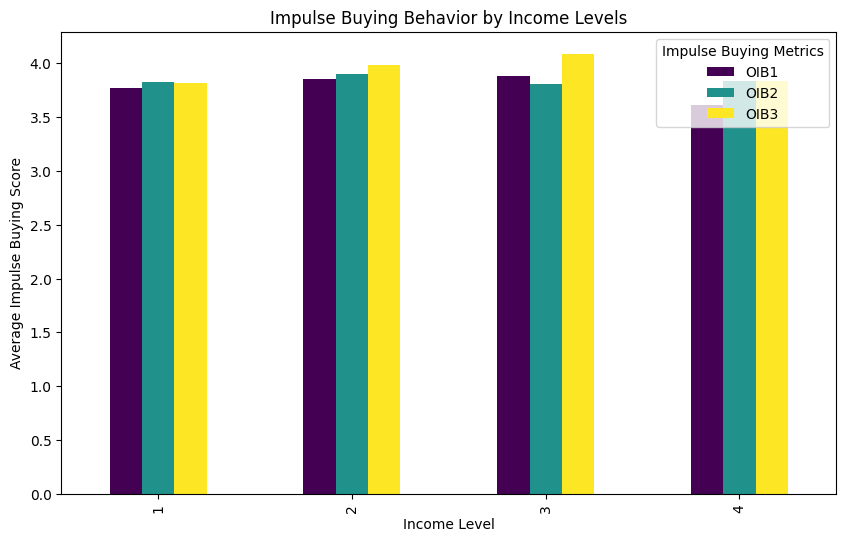

In [11]:
# Filter oib_vars to include only numeric columns
numeric_oib_vars = df[oib_vars].select_dtypes(include=['number']).columns
income_groups = df.groupby('Q4_INCOME')[numeric_oib_vars].mean()

income_groups.plot(kind='bar', figsize=(10, 6), colormap='viridis')
plt.title("Impulse Buying Behavior by Income Levels")
plt.xlabel("Income Level")
plt.ylabel("Average Impulse Buying Score")
plt.legend(numeric_oib_vars, title="Impulse Buying Metrics")
plt.show()

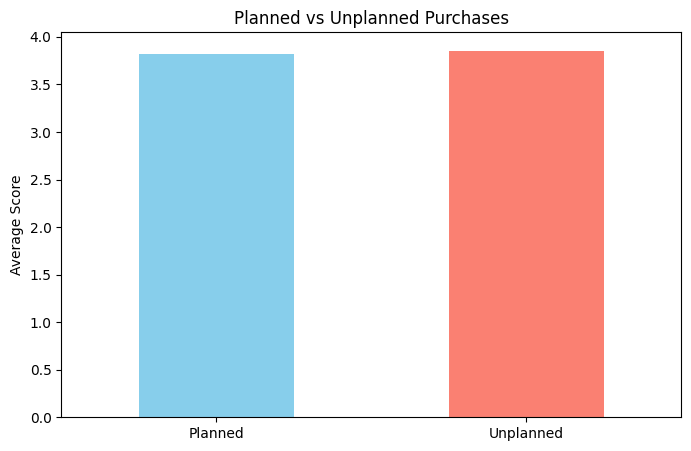

In [12]:
# Planned vs. Unplanned Purchases
planned_vs_unplanned = df[['OIB1', 'OIB2']].mean()
planned_vs_unplanned.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'])
plt.title("Planned vs Unplanned Purchases")
plt.xticks(ticks=[0, 1], labels=['Planned', 'Unplanned'], rotation=0)
plt.ylabel("Average Score")
plt.show()

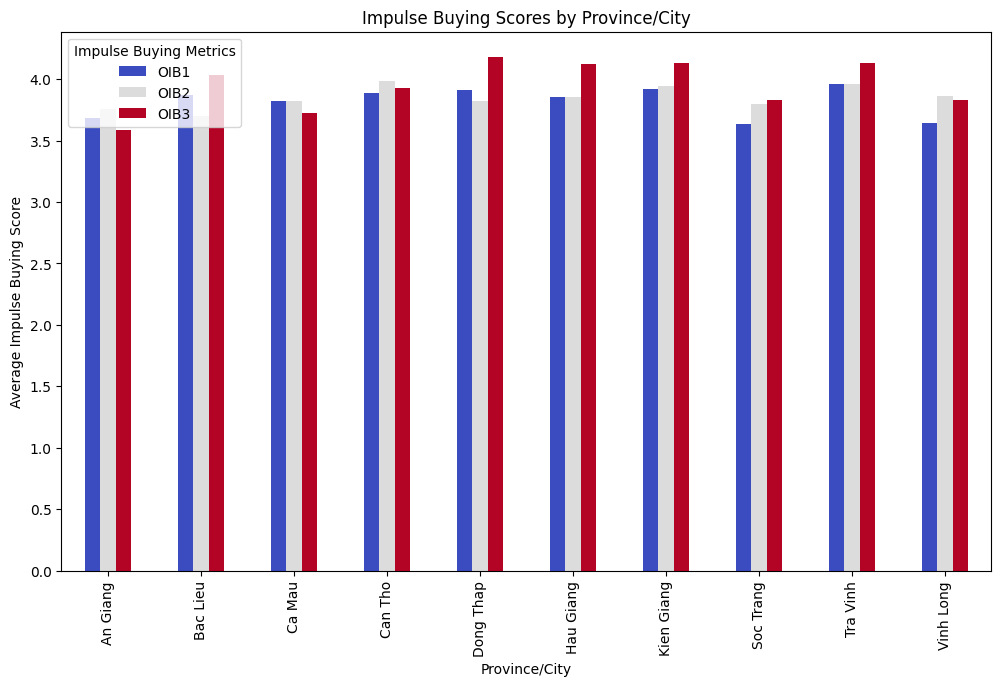

In [13]:
province_insights = df.groupby('Q1_PROVINCE/CITY').mean()[oib_vars]
province_insights.plot(kind='bar', figsize=(12, 7), colormap='coolwarm')
plt.title("Impulse Buying Scores by Province/City")
plt.xlabel("Province/City")
plt.ylabel("Average Impulse Buying Score")
plt.legend(oib_vars, title="Impulse Buying Metrics")
plt.show()

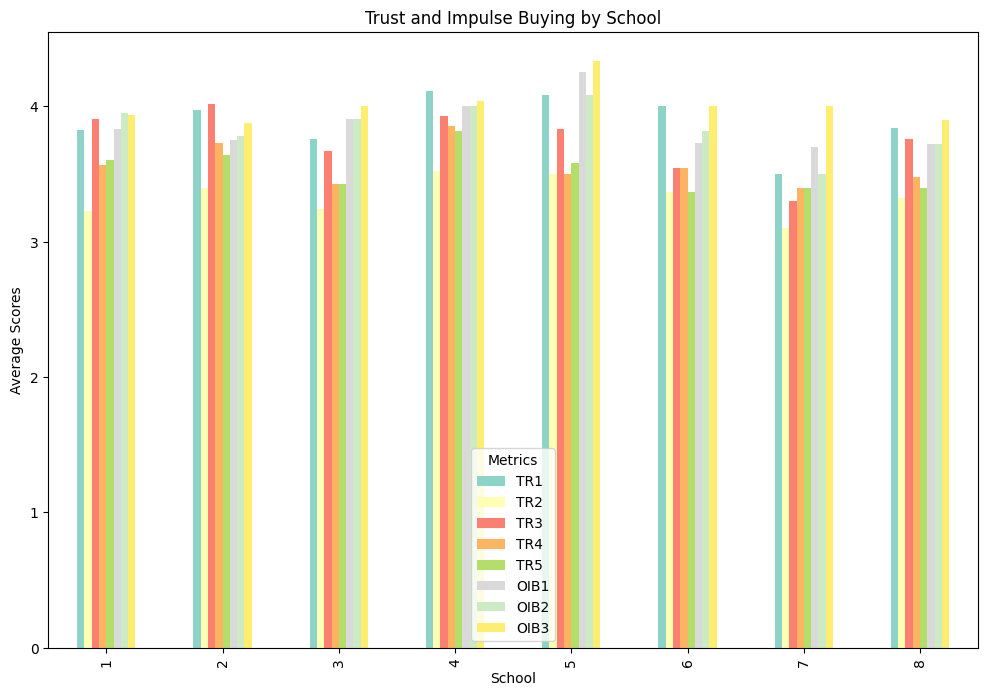

In [14]:
# Select only numeric columns for the aggregation
numeric_cols = trust_vars + oib_vars
school_insights = df.groupby('Q3_SCHOOL')[numeric_cols].mean()

# Plot the results
school_insights.plot(kind='bar', figsize=(12, 8), colormap='Set3')
plt.title("Trust and Impulse Buying by School")
plt.xlabel("School")
plt.ylabel("Average Scores")
plt.legend(title="Metrics")
plt.show()

In [15]:
print(df['Q3_SCHOOL'].unique())

[1 3 2 7 5 4 8 6]


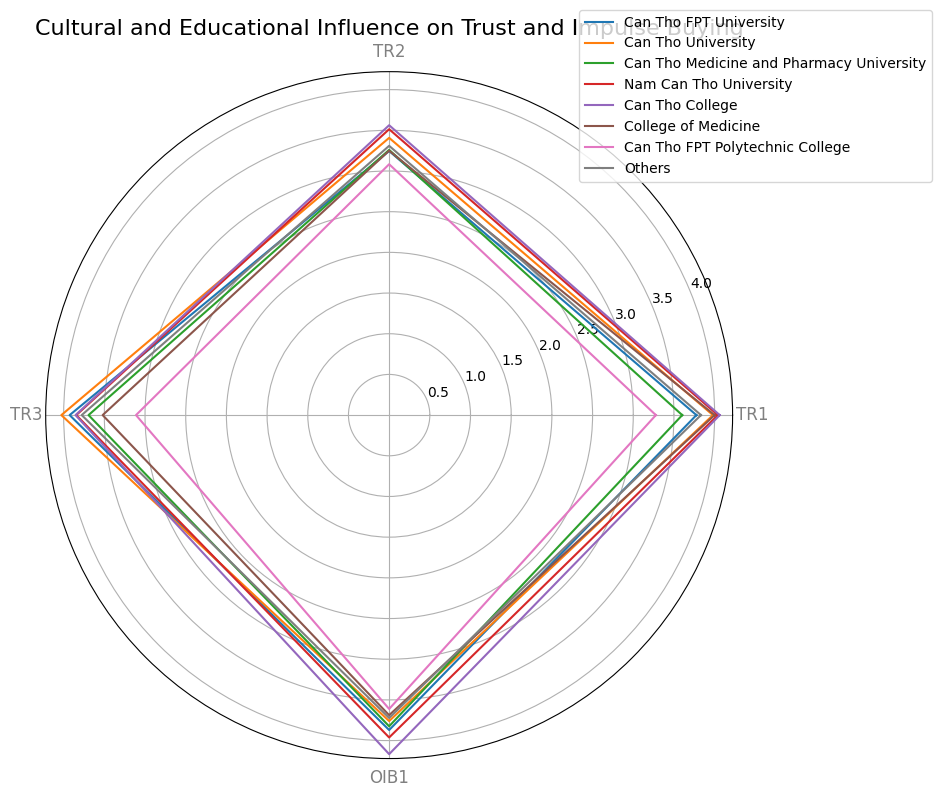

In [16]:
from math import pi
import matplotlib.pyplot as plt

# Define the school mapping
school = {
    1: 'Can Tho FPT University',
    2: 'Can Tho University',
    3: 'Can Tho Medicine and Pharmacy University',
    4: 'Nam Can Tho University',
    5: 'Can Tho College',
    6: 'College of Medicine',
    7: 'Can Tho FPT Polytechnic College',
    8: 'Others'
}

# Group by school and province
edu_cultural_data = df.groupby(['Q3_SCHOOL', 'Q1_PROVINCE/CITY'])[['TR1', 'TR2', 'TR3', 'OIB1']].mean()

# Reset index and map school labels
edu_cultural_data.reset_index(inplace=True)
edu_cultural_data['School'] = edu_cultural_data['Q3_SCHOOL'].map(school)

# Radar chart preparation for schools
categories = ['TR1', 'TR2', 'TR3', 'OIB1']
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Complete the loop

# Create the radar chart
plt.figure(figsize=(10, 8))

for school_label in edu_cultural_data['School'].unique():
    school_data = edu_cultural_data[edu_cultural_data['School'] == school_label]
    avg_values = school_data[categories].mean(axis=0).values
    avg_values = avg_values.tolist()
    avg_values += avg_values[:1]  # Complete the loop

    plt.polar(angles, avg_values, label=school_label)

# Add labels, title, and legend
plt.xticks(angles[:-1], categories, color='grey', size=12)
plt.title("Cultural and Educational Influence on Trust and Impulse Buying", size=16)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

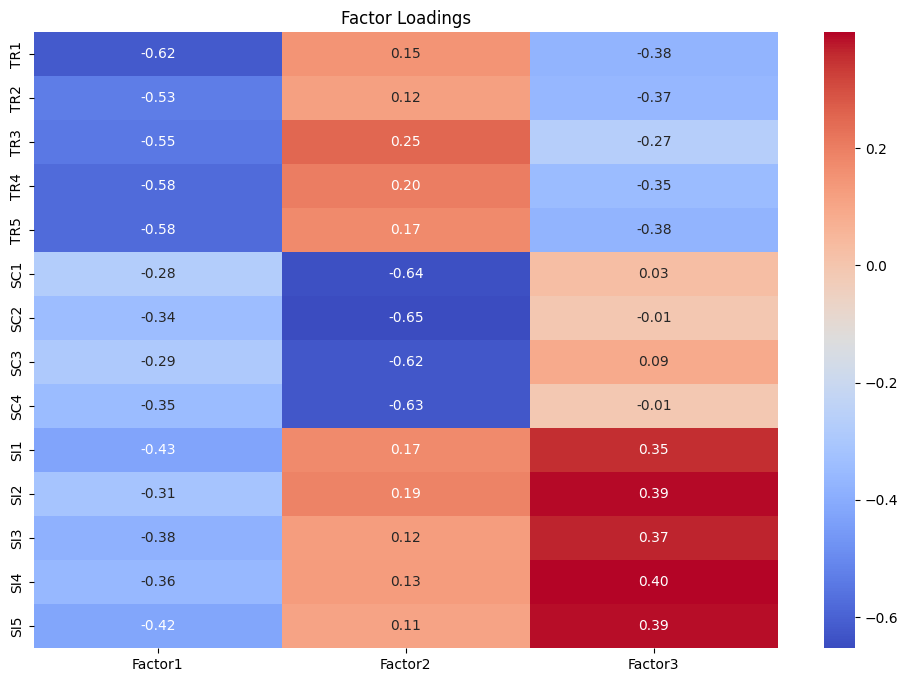

In [17]:
# Factor Analysis (Exploratory Factor Analysis)
from sklearn.decomposition import FactorAnalysis

# Prepare data for factor analysis
fa_vars = trust_vars + ['SC1', 'SC2', 'SC3', 'SC4', 'SI1', 'SI2', 'SI3', 'SI4', 'SI5']
X_fa = df[fa_vars].dropna()

# Perform Factor Analysis
fa = FactorAnalysis(n_components=3, random_state=42)
factors = fa.fit_transform(X_fa)

# Attach factors to the original DataFrame
df['Factor1'], df['Factor2'], df['Factor3'] = factors[:, 0], factors[:, 1], factors[:, 2]

# Visualize factor loadings
factor_loadings = pd.DataFrame(fa.components_, columns=fa_vars, index=['Factor1', 'Factor2', 'Factor3']).T
plt.figure(figsize=(12, 8))
sns.heatmap(factor_loadings, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Factor Loadings")
plt.show()

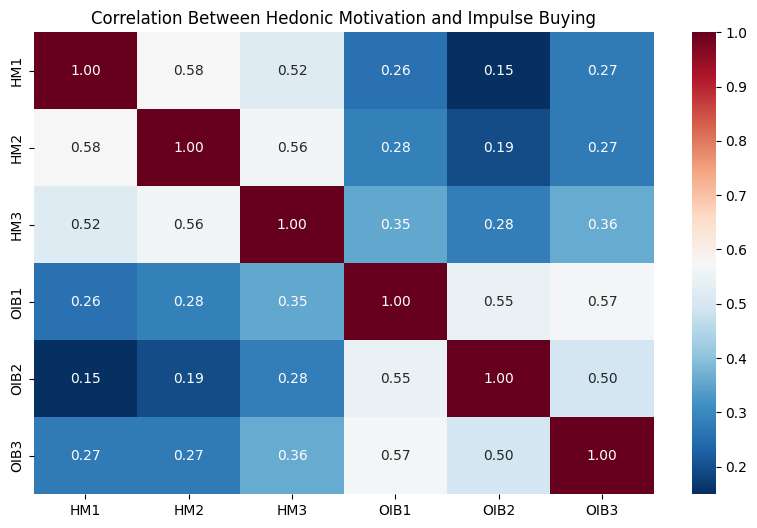

In [18]:
hedonic_vars = ['HM1', 'HM2', 'HM3']
relaxation_effects = df[hedonic_vars + oib_vars].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(relaxation_effects, annot=True, cmap='RdBu_r', fmt='.2f')
plt.title("Correlation Between Hedonic Motivation and Impulse Buying")
plt.show()